# 🩺 Análisis Exploratorio: Dataset Flaredown

**Objetivo:** Analizar datos históricos de síntomas para predicción de brotes en Crohn/IBD

**Dataset:** Flaredown Autoimmune Symptom Tracker

**Estructura confirmada:**
- `user_id`: ID del usuario
- `checkin_date`: Fecha del registro
- `trackable_type`: Tipo (Condition, Symptom, Treatment, etc.)
- `trackable_name`: Nombre ("Crohn's disease", "Diarrhea", etc.)
- `trackable_value`: Valor/severidad (0-4 o yes/no)

**Autor:** Asier Ortiz García

**Fecha:** Octubre 2025

## 📦 Imports y Configuración

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import os
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
%matplotlib inline

os.makedirs('../docs/figures', exist_ok=True)
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../models', exist_ok=True)

print("=" * 80)
print("ANÁLISIS EXPLORATORIO: Dataset Flaredown para Predicción de Brotes")
print("=" * 80)

ANÁLISIS EXPLORATORIO: Dataset Flaredown para Predicción de Brotes


## 1️⃣ Carga Inicial

In [78]:
print("📊 Cargando muestra del dataset...\n")
# df_sample = pd.read_csv('../data/raw/export.csv', nrows=10000)
df_sample = pd.read_csv('../data/raw/export.csv')

print(f"✓ Muestra: {df_sample.shape[0]:,} registros × {df_sample.shape[1]} columnas\n")
print("📋 Columnas:")
print(df_sample.columns.tolist())
print("\n📊 Info:")
print(df_sample.info())

📊 Cargando muestra del dataset...

✓ Muestra: 7,976,223 registros × 9 columnas

📋 Columnas:
['user_id', 'age', 'sex', 'country', 'checkin_date', 'trackable_id', 'trackable_type', 'trackable_name', 'trackable_value']

📊 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7976223 entries, 0 to 7976222
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   user_id          object 
 1   age              float64
 2   sex              object 
 3   country          object 
 4   checkin_date     object 
 5   trackable_id     object 
 6   trackable_type   object 
 7   trackable_name   object 
 8   trackable_value  object 
dtypes: float64(1), object(8)
memory usage: 547.7+ MB
None


In [79]:
df_sample.head(10)

,user_id,age,sex,country,checkin_date,trackable_id,trackable_type,trackable_name,trackable_value
0,QEVuQwEABlEzkh7fsBBjEe26RyIVcg==,NaN,NaN,NaN,2015-11-26,1069,Condition,Ulcerative colitis,0
1,QEVuQwEAWRNGnuTRqXG2996KSkTIEw==,32.0,male,US,2015-11-26,1069,Condition,Ulcerative colitis,0
2,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,3168,Condition,pain in left upper arm felt like i was getting...,4
3,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,3169,Condition,hip pain when gettin up,3
4,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,3170,Condition,pain in hand joints,4
5,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,3171,Condition,numbness in right hand,2
6,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,1356,Condition,Headache,2
7,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,3172,Condition,pain in left ankle,1
8,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,3173,Condition,pain in left leg,1
9,QEVuQwEA+WkNxtp/qkHvN2YmTBBDqg==,2.0,female,CA,2017-04-28,3174,Condition,pain in joints on feet,2


## 2️⃣ Carga Completa

In [80]:
def load_data(filepath, sample_size=None):
    if sample_size:
        n_lines = sum(1 for _ in open(filepath)) - 1
        skip = np.random.choice(range(1, n_lines), n_lines - sample_size, replace=False)
        df = pd.read_csv(filepath, skiprows=skip)
    else:
        df = pd.read_csv(filepath, low_memory=False)
    return df

SAMPLE_SIZE = 100000  # Ajusta según RAM
# df = load_data('../data/raw/export.csv', sample_size=SAMPLE_SIZE)
df = pd.read_csv('../data/raw/export.csv', low_memory=False)
print(f"✓ Cargado: {len(df):,} registros")

✓ Cargado: 7,976,223 registros


## 3️⃣ Preparación de Datos

In [81]:
df['checkin_date'] = pd.to_datetime(df['checkin_date'], errors='coerce')
df['year'] = df['checkin_date'].dt.year
df['month'] = df['checkin_date'].dt.month
df['day_of_week'] = df['checkin_date'].dt.dayofweek

print(f"Rango: {df['checkin_date'].min()} → {df['checkin_date'].max()}")
print(f"Usuarios: {df['user_id'].nunique():,}")
print(f"\nTipos de trackables:")
print(df['trackable_type'].value_counts())

Rango: 2012-05-18 00:00:00 → 2019-12-06 00:00:00
Usuarios: 42,283

Tipos de trackables:
trackable_type
Symptom      3642279
Weather      1393806
Condition    1111517
Treatment     901820
Food          480971
Tag           445669
HBI              161
Name: count, dtype: int64


## 4️⃣ Filtrar Usuarios con Crohn

In [82]:
conditions_df = df[df['trackable_type'] == 'Condition']
print(f"Condiciones: {len(conditions_df):,} registros\n")

print("Top 20 condiciones:")
print(conditions_df['trackable_name'].value_counts().head(20))

ibd_keywords = ['crohn', 'ibd', 'colitis', 'inflammatory bowel', 'ulcerative']
ibd_mask = conditions_df['trackable_name'].str.contains('|'.join(ibd_keywords), case=False, na=False)

print(f"\nCondiciones IBD encontradas:")
print(conditions_df[ibd_mask]['trackable_name'].value_counts())

ibd_user_ids = conditions_df[ibd_mask]['user_id'].unique()
print(f"\n✓ Usuarios con Crohn/IBD: {len(ibd_user_ids):,}")

df_crohn = df[df['user_id'].isin(ibd_user_ids)].copy()
print(f"✓ Registros totales: {len(df_crohn):,}")
print(f"\nDistribución por tipo:")
print(df_crohn['trackable_type'].value_counts())

Condiciones: 1,111,517 registros

Top 20 condiciones:
trackable_name
Fibromyalgia                    55255
Depression                      50109
Anxiety                         46968
Chronic fatigue syndrome        28259
Migraine                        26082
IBS                             17324
Fatigue                         14920
Asthma                          14218
Endometriosis                   13873
Ehlers-Danlos syndrome          13677
Irritable bowel syndrome        11801
Headaches                       11362
Generalized anxiety disorder    10275
Chronic Migraines               10034
joint pain                       9781
POTS                             8946
Allergies                        8722
Chronic Pain                     8367
Insomnia                         7784
Rheumatoid arthritis             7243
Name: count, dtype: int64

Condiciones IBD encontradas:
trackable_name
Ulcerative colitis                                5930
Crohn's disease                              

## 5️⃣ Análisis de Síntomas

Síntomas: 161,086 registros
Síntomas únicos: 2,159

Top 20 síntomas:
trackable_name
Diarrhea                 8307
Fatigue                  6695
Nausea                   5371
Abdominal pain           5202
Headache                 4112
Joint pain               3926
Bloating                 3292
Stomach Pain             3114
Constipation             2838
Fatigue and tiredness    2678
Bloody Stools            2562
Gas                      2253
Bowel Urgency            1932
Anxiety                  1892
Brain fog                1863
Lower abdomen pain       1842
Stiffness                1790
bowel movements          1720
Depression               1454
lightheadedness          1433
Name: count, dtype: int64


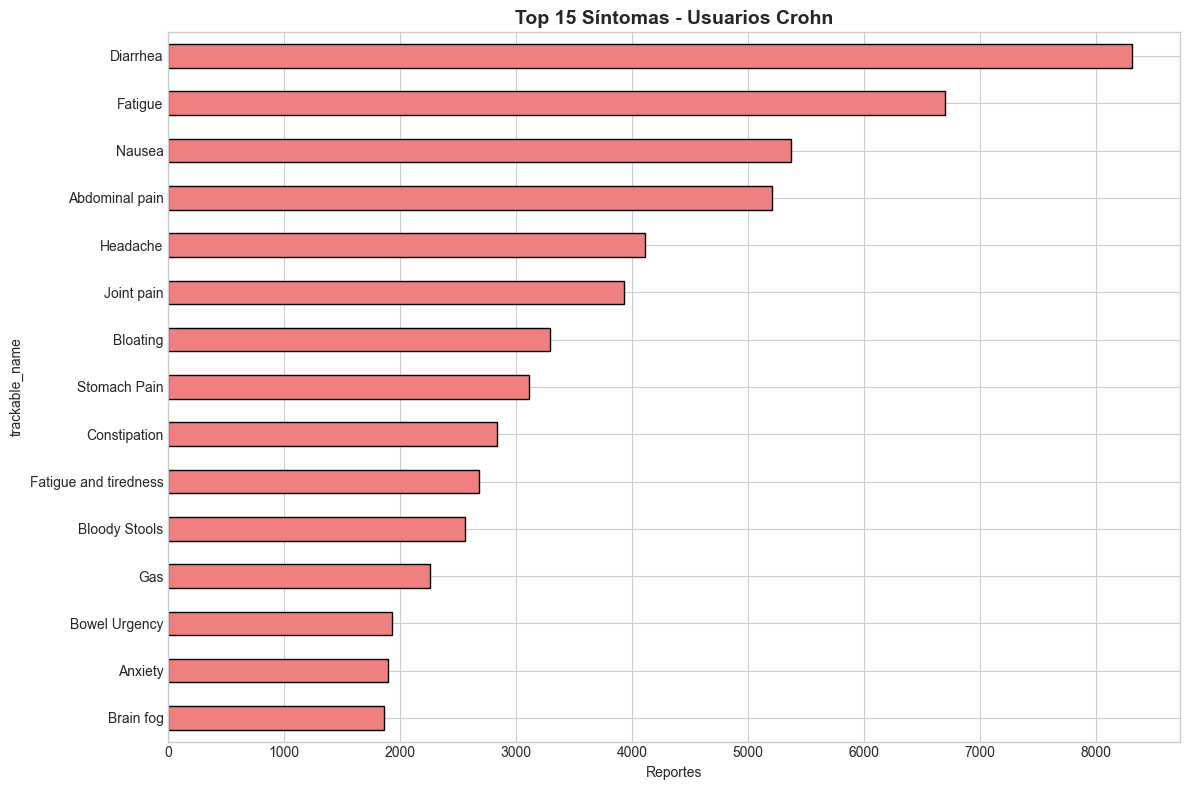

In [83]:
symptoms = df_crohn[df_crohn['trackable_type'] == 'Symptom']
print(f"Síntomas: {len(symptoms):,} registros")
print(f"Síntomas únicos: {symptoms['trackable_name'].nunique():,}\n")

top_symptoms = symptoms['trackable_name'].value_counts().head(20)
print("Top 20 síntomas:")
print(top_symptoms)

plt.figure(figsize=(12, 8))
top_symptoms.head(15).plot(kind='barh', color='lightcoral', edgecolor='black')
plt.title('Top 15 Síntomas - Usuarios Crohn', fontsize=14, fontweight='bold')
plt.xlabel('Reportes')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../docs/figures/top_symptoms.png', dpi=300, bbox_inches='tight')
plt.show()

## 6️⃣ Análisis de Severidad

In [84]:
df_crohn['value_numeric'] = pd.to_numeric(df_crohn['trackable_value'], errors='coerce')

print("Valores (top 20):")
print(df_crohn['trackable_value'].value_counts().head(20))

numeric_mask = df_crohn['value_numeric'].notna()
print(f"\nNuméricos: {numeric_mask.sum():,} ({numeric_mask.sum()/len(df_crohn)*100:.1f}%)")
print(f"No numéricos: {(~numeric_mask).sum():,}")

if numeric_mask.sum() > 0:
    print(f"\nEstadísticas (valores numéricos):")
    print(f"  Media: {df_crohn['value_numeric'].mean():.2f}")
    print(f"  Mediana: {df_crohn['value_numeric'].median():.2f}")
    print(f"  Min-Max: {df_crohn['value_numeric'].min():.0f} - {df_crohn['value_numeric'].max():.0f}")

Valores (top 20):
trackable_value
0                      75089
1                      53002
2                      46026
3                      28541
4                      15344
partly-cloudy-day       3641
rain                    2387
1.0 tablet              2180
0.0                     2012
30.0 mg                 1726
150.0 mcg               1548
partly-cloudy-night     1462
1000.0 IU               1439
0.5 packet              1408
2 capsules              1403
1 capsule               1350
150.0 mg                1099
2 x 500mg               1033
20 ml                   1011
0.0001                   993
Name: count, dtype: int64

Numéricos: 268,473 (68.7%)
No numéricos: 122,292

Estadísticas (valores numéricos):
  Media: 46.20
  Mediana: 1.00
  Min-Max: -44 - 10000


## 7️⃣ Análisis Temporal

In [85]:
print("Registros por año:")
print(df_crohn['year'].value_counts().sort_index())

print("\nRegistros por mes:")
months = ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
for m, c in df_crohn['month'].value_counts().sort_index().items():
    print(f"  {months[int(m)-1]}: {c:,}")

Registros por año:
year
2015     29010
2016     48170
2017     91805
2018    128752
2019     93028
Name: count, dtype: int64

Registros por mes:
  Ene: 26,896
  Feb: 28,506
  Mar: 30,871
  Abr: 29,789
  May: 32,534
  Jun: 36,269
  Jul: 38,557
  Ago: 35,463
  Sep: 32,964
  Oct: 35,240
  Nov: 38,282
  Dic: 25,394


## 8️⃣ Análisis de Usuarios

In [86]:
records_per_user = df_crohn['user_id'].value_counts()
print(f"Usuarios: {len(records_per_user):,}")
print(f"\nRegistros por usuario:")
print(f"  Media: {records_per_user.mean():.1f}")
print(f"  Mediana: {records_per_user.median():.1f}")
print(f"  Max: {records_per_user.max():,}")

active = records_per_user[records_per_user >= 30]
print(f"\n✓ Usuarios con ≥30 registros: {len(active):,} ({len(active)/len(records_per_user)*100:.1f}%)")

Usuarios: 2,046

Registros por usuario:
  Media: 191.0
  Mediana: 20.0
  Max: 66,151

✓ Usuarios con ≥30 registros: 782 (38.2%)


## 9️⃣ Viabilidad LSTM

In [87]:
user_ranges = df_crohn.groupby('user_id')['checkin_date'].agg(['min', 'max', 'count'])
user_ranges['days'] = (user_ranges['max'] - user_ranges['min']).dt.days

viable = user_ranges[user_ranges['days'] >= 30]
ideal = user_ranges[user_ranges['days'] >= 90]

print(f"Usuarios con ≥30 días: {len(viable):,}")
print(f"Usuarios con ≥90 días: {len(ideal):,}")
print(f"\nDías promedio: {viable['days'].mean():.1f}")
print(f"Registros promedio: {viable['count'].mean():.1f}")
print(f"\n✓ VIABLE para LSTM" if len(viable) > 20 else "⚠️ Pocos usuarios viables")

Usuarios con ≥30 días: 513
Usuarios con ≥90 días: 323

Días promedio: 250.4
Registros promedio: 664.2

✓ VIABLE para LSTM


## 🔟 Guardar Datos

In [88]:
output = '../data/processed/crohn_filtered.csv'
df_crohn.to_csv(output, index=False)
print(f"✓ Guardado: {output}")
print(f"  Tamaño: {os.path.getsize(output)/(1024**2):.2f} MB")

if len(df_crohn) > 10000:
    sample = df_crohn.sample(10000, random_state=42)
    sample.to_csv('../data/processed/crohn_sample_10k.csv', index=False)
    print(f"✓ Muestra guardada (10k registros)")

✓ Guardado: ../data/processed/crohn_filtered.csv
  Tamaño: 37.52 MB
✓ Muestra guardada (10k registros)


## ✅ Resumen

### Dataset confirmado:
- ✅ Usuarios con Crohn/IBD identificados
- ✅ Datos temporales (series de tiempo)
- ✅ Síntomas, tratamientos, condiciones
- ✅ Viable para modelos LSTM

### Próximos pasos:
1. Crear `02_data_cleaning.ipynb`
2. Limpiar `trackable_value` (separar numérico/categórico)
3. Normalizar nombres de síntomas
4. Definir variable objetivo "brote"
5. Feature engineering temporal